In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
plt.rcParams['text.usetex'] = True

In [2]:
# Constants in CGS units
sigma_sb = 5.67051e-5
Na = 6.0221415e23
Rg = 8.314
c = 2.99792458e10
G = 6.67259e-8
k = 1.380658e-16
a = 7.5646e-15

Ms = 1.989e33
Rs = 6.96e10
Ls = 3.826e33

#### importing opacity from OPAL 
(https://opalopacity.llnl.gov/existing.html)

In [3]:
file_name = 'GN93hz.txt'
start_line = 242
table_row_length = 77
tables = {}

with open(file_name) as f:
    lines = f.readlines()

for i in range(126):
    table = {}
    title_items = lines[start_line + table_row_length * i - 1].split()

    table_name = f'Table {title_items[2]}'
    if i < 99:
        X = float(title_items[5].split('=')[1])
        Y = float(title_items[6].split('=')[1])
        Z = float(title_items[7].split('=')[1])
        dXc = float(title_items[8].split('=')[1])
        dXo = float(title_items[9].split('=')[1])
    else:
        X = float(title_items[4].split('=')[1])
        Y = float(title_items[5].split('=')[1])
        Z = float(title_items[6].split('=')[1])
        dXc = float(title_items[7].split('=')[1])
        dXo = float(title_items[8].split('=')[1])

    table['Composition'] = {'X': X, 'Y': Y, 'Z': Z, 'dXc': dXc, 'dXo': dXo}
    log_R_str = lines[start_line + table_row_length * i + 4 - 1].split()[1:]
    log_R = np.array([float(t) for t in log_R_str])
    table['log_R'] = log_R
    table_val = np.zeros((70, len(log_R)))
    log_T = []
    for j in range(70):
        line_to_process = lines[start_line + table_row_length * i + 5 + j].split()
        log_T.append(float(line_to_process[0]))
        val_str = lines[start_line + table_row_length * i + 5 + j].split()[1:]
        val = np.array([float(t) for t in val_str])
        table_val[j, 0:val.shape[0]] = val
    table['name'] = table_name
    table['log_T'] = np.array(log_T)
    table['val'] = table_val
    tables[table_name] = table

#### Scientific functions

In [4]:
def get_opacity_table(X, Y, Z):
    for i, table_name in enumerate(tables.keys()):
        if tables[table_name]['Composition']['X'] == X and tables[table_name]['Composition']['Y'] == Y and tables[table_name]['Composition']['Z'] == Z:
            table = tables[table_name]
            break
        if i == len(tables.keys()) - 1:
            raise ('Not found')
    return table

In [5]:
def get_epsilon_pp(rho, T):
    T9 = T*1e-9
    T7 = T*1e-7

    # shielding factor
    Z1 = 1
    Z2 = 1
    zeta = 1
    if not isinstance(rho, np.ndarray):
        if rho < 0:
            rho = 0

    f11 = np.exp(5.92e-3*Z1*Z2*np.sqrt(zeta*rho*(T7)**-3))
    # pp chain
    psi = 1  # for pp1
    g11 = 1 + 3.82*T9 + 1.51*T9**2 + 0.144*T9**3 - 0.0114*T9**4
    epsilon_pp = 2.57e4 * psi * f11 * g11 * rho * X**2 * T9**(-2/3) * np.exp(-3.381*T9**(-1/3))

    return epsilon_pp


def get_epsilon_cno(rho, T):
    T9 = T*1e-9
    # CNO cycle
    # X_cno = X_c + X_n + X_o
    X_cno = 0.7 * Z  # between 2/3 and 3/4 of Z

    g14_1 = 1 - 2.00*T9 + 3.41*T9**2 - 2.43*T9**3
    epsilon_cno = 8.24e25 * g14_1 * X_cno * X * rho * T9**(-2/3) * np.exp(-15.231*T9**(-1/3) - (T9/0.8)**2)

    return epsilon_cno


def get_epsilon_energy_generation(rho, T):
    epsilon_pp = get_epsilon_pp(rho, T)
    epsilon_cno = get_epsilon_cno(rho, T)
    epsilon = epsilon_pp + epsilon_cno
    return epsilon

In [6]:
def get_opacity(interp, rho, T):
    R = rho / (T*1e-6)**3
    if not isinstance(R, np.ndarray):
        if R < 1e-8:
            R = 1e-8
    log_R = np.log10(R)
    log_T = np.log10(T)

    if not isinstance(T, np.ndarray):
        if log_T < 3.75 or log_T > 8.70:
            if log_T > 8.70:
                log_T = 8.70
            if log_T < 3.75:
                log_T = 3.75
            # raise ValueError('log_T out of range')

    if not isinstance(R, np.ndarray):
        if log_R < -8.0 or log_R > 1.0:
            if log_R > 1.0:
                log_R = 1.0
            if log_R < -8.0:
                log_R = -8.0
            raise ValueError('log_R out of range')

    log_kappa = interp((log_T, log_R))
    return 10**log_kappa

In [7]:
def get_density_rho(P, T, mu):
    rho = (P/T - a * T**3 / 3) * mu / (Na * k)
    return rho


def get_pressure_p(rho, T, mu):
    P = rho * Na * k * T / mu + a * T**4 / 3
    return P


def get_del_rad(Mr, P, L, T, kappa):
    del_rad = 3 / (16 * np.pi * a * c * G) * (P * kappa * L) / (T**4 * Mr)
    return del_rad


def get_del_ad(P, T):
    P_rad = 1/3 * a * T**4
    b = 1 - (P_rad / P)
    del_ad = 2 * (4-3*b)/(32-24*b-3*b**2)
    return del_ad


def get_del_nabla(Mr, P, L, T, kappa):
    nabla_del = np.nanmin([get_del_rad(Mr, P, L, T, kappa), get_del_ad(P, T)], axis=0)
    return nabla_del

In [8]:
def diff_eqs(Mr, y, args):
    P, r, L, T = y
    mu = args['mu']
    opacity_interp = args['opacity_interp']

    # P_rad = a * T**4 / 3
    # rho = (P - P_rad) * mu / (Na * k * T)
    rho = get_density_rho(P, T, mu)

    kappa = get_opacity(opacity_interp, rho, T)

    dPdMr = -(G * Mr) / (4 * np.pi * r**4)
    drdMr = 1 / (4 * np.pi * r**2 * rho)
    dLrdMr = get_epsilon_energy_generation(rho, T)

    dTdMr = get_del_nabla(Mr, P, L, T, kappa) * dPdMr * (T/P)

    return [dPdMr, drdMr, dLrdMr, dTdMr]

In [9]:
# near centre
def load1(stellar_variables, args):
    Pc, R, L, Tc = stellar_variables
    M = args[0]['M']
    mu = args[0]['mu']

    Mcp = 1e-10 * M
    rho_cp = get_density_rho(Pc, Tc, mu)
    rcp = (3*Mcp/(4*np.pi*rho_cp))**(1/3)

    Pcp = Pc - (3 * G / 8 / np.pi) * (4 * np.pi * rho_cp / 3)**(4/3) * Mcp**(2/3)

    epsilon = get_epsilon_energy_generation(rho_cp, Tc)
    Lcp = epsilon * Mcp
    Tcp = Tc
    return [Pcp, rcp, Lcp, Tcp]


# Eddington gray atmosphere method
def Eddington_derivative(tau, P, stellar_variables, args):
    Pc, R, L, Tc = stellar_variables
    M = args[0]['M']
    mu = args[0]['mu']
    opacity_interp = args[0]['opacity_interp']

    T = (3/4 * L / (4 * np.pi * sigma_sb * R**2) * (tau + 2/3))**(1/4)
    rho = get_density_rho(P, T, mu)[0]

    kappa = get_opacity(opacity_interp, rho, T)
    dPdtau = G * M / R**2 / kappa
    return dPdtau


# surface
def load2(stellar_variables, args):
    Pc, R, L, Tc = stellar_variables
    M = args[0]['M']
    T_eff = (L / (4*np.pi*R**2*sigma_sb))**(1/4)
    g_srf = G * M / R**2

    P_boundary = 1/3 * a * T_eff**4
    P_arr = scipy.integrate.solve_ivp(Eddington_derivative, y0=[P_boundary], t_span=(0, 2/3), t_eval=np.linspace(0, 2/3), args=[stellar_variables, args], method='RK45').y
    Psrf = P_arr.max()
    return [Psrf, R, L, T_eff]

In [10]:
def shootf(stellar_variables, args, detailed=False, M_meeting_point = 0.5
,M_start=1e-5):
    P, R, L, T = stellar_variables
    M = args[0]['M']
    steps = 100 if not detailed else 10000
    Mr_array_from_centre = np.linspace(M_start, M_meeting_point, steps) * M
    sol_from_centre = scipy.integrate.solve_ivp(diff_eqs, (Mr_array_from_centre[0], Mr_array_from_centre[-1]), load1(stellar_variables, args), args=args, method='RK45', t_eval=Mr_array_from_centre)
    Mr_array_from_surface = np.linspace(1, M_meeting_point, steps) * M
    sol_from_surface = scipy.integrate.solve_ivp(diff_eqs, (Mr_array_from_surface[0], Mr_array_from_surface[-1]), load2(stellar_variables, args), args=args, method='RK45', t_eval=Mr_array_from_surface)
    return sol_from_centre, sol_from_surface

In [11]:
def residuals(param_scales, initial_guess, args):
    stellar_variables = initial_guess * param_scales
    sol_from_centre, sol_from_surface = shootf(stellar_variables, args)
    scale = (sol_from_surface.y[:, 0] - sol_from_centre.y[:, 0])
    diff_frac = (sol_from_centre.y[:, -1] - sol_from_surface.y[:, -1]) / scale
    chi2 = np.sum(diff_frac**2)
    return np.sum(chi2)

### Main code to run for calculation

In [12]:
M = 1.5 * Ms
X = 0.7
Y = 0.28
Z = 0.02

mu = 4 / (3 + 5*X)

table = get_opacity_table(X, Y, Z)
opacity_interp = scipy.interpolate.RegularGridInterpolator((table['log_T'], table['log_R']), table['val'], bounds_error=False)

args = [{'M': M, 'mu': 0.6, 'opacity_interp': opacity_interp}]

In [13]:
# Initial guess
# homology relations for low-mass stars
R = Rs * (M / Ms)**0.75
L = Ls * (M / Ms)**3.5

# constant density model
Pc = 3 / (8 * np.pi) * G * M**2 / R**4
Tc = 1/2 * G * M / R * mu / (Na * k)

# Solar values from NASA Sun Fact Sheet
Pc = 1.92e17
Tc = 1.57e7
initial_guess = np.array([Pc, R, L, Tc])
initial_guess

array([1.92000000e+17, 9.43360492e+10, 1.58148243e+34, 1.57000000e+07])

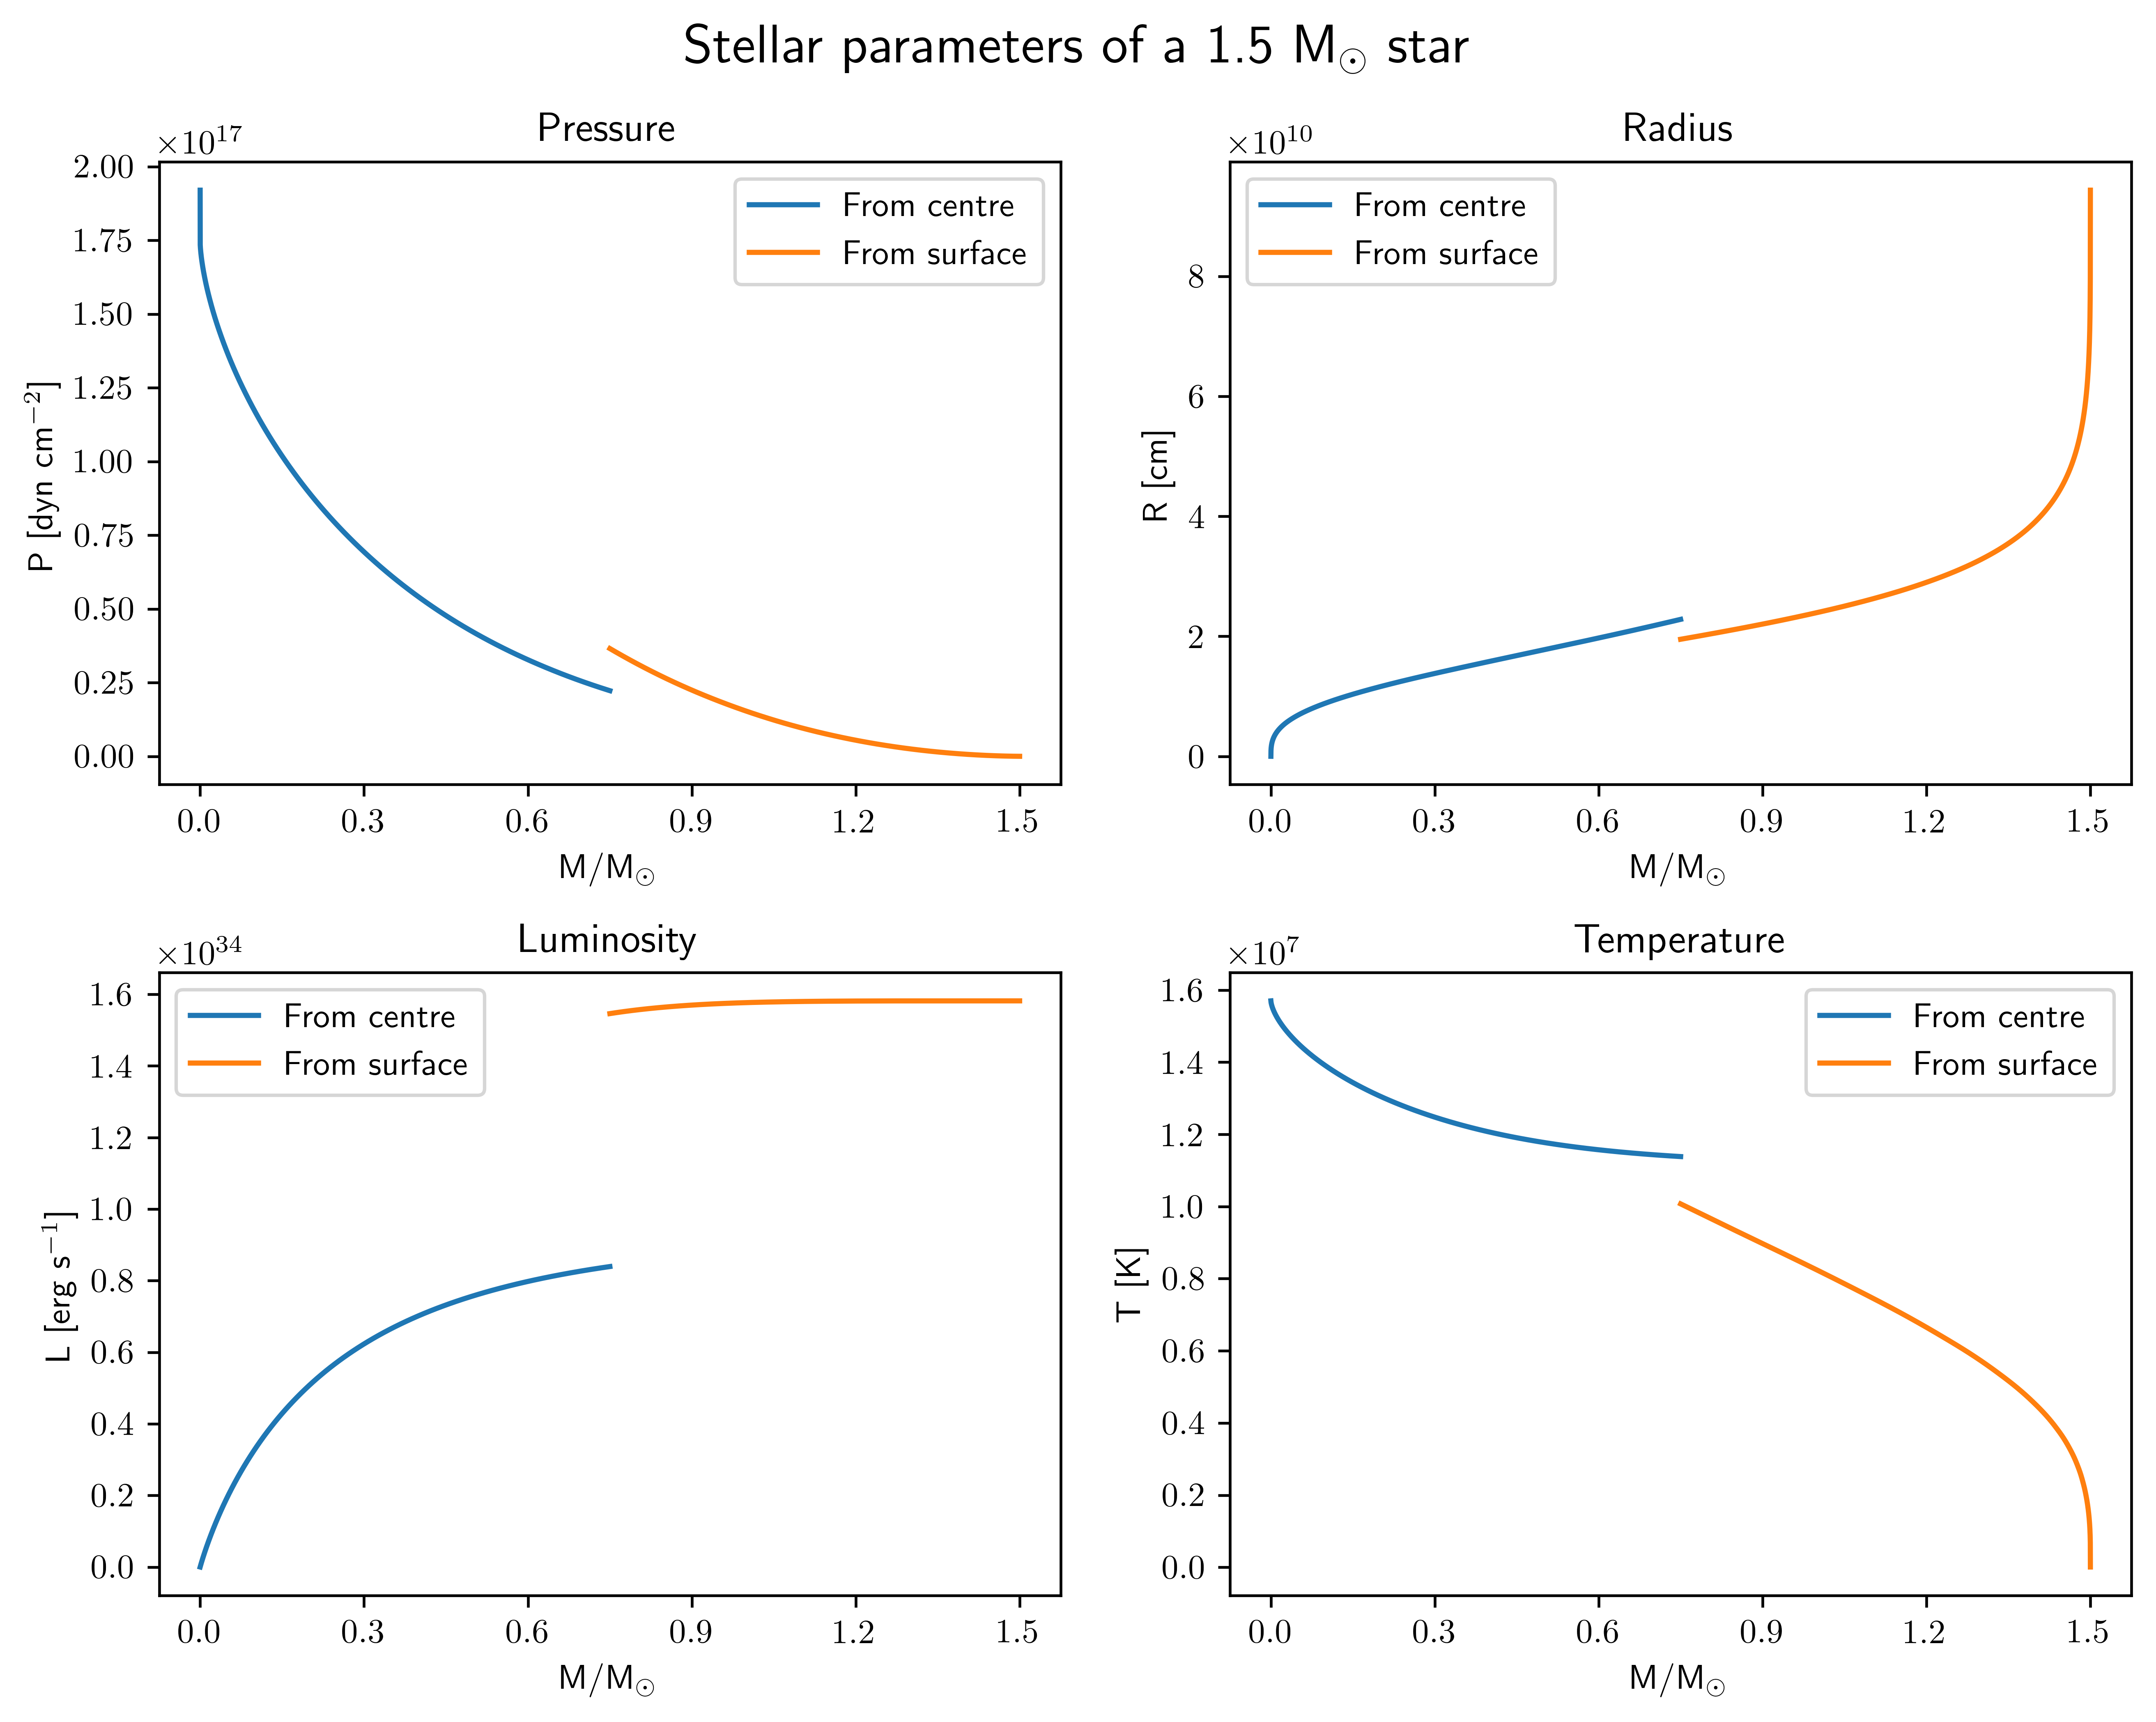

In [14]:
sol1, sol2 = shootf(initial_guess, args, detailed=True, M_start=1e-5)

fig, axs = plt.subplots(2, 2, figsize=(3.54*2.5, 3.54*2), dpi=600)
axs[0, 0].plot(sol1.t/Ms, sol1.y[0, :])
axs[0, 0].plot(sol2.t/Ms, sol2.y[0, :])
axs[0, 0].set_title('Pressure')
axs[0, 0].set_xlabel('M/M$_\odot$')
axs[0, 0].set_ylabel('P [dyn cm$^{-2}$]')
axs[0, 0].set_xticks(np.linspace(0, 1.5, 6))
axs[0, 0].legend(['From centre', 'From surface'])

axs[0, 1].plot(sol1.t/Ms, sol1.y[1, :])
axs[0, 1].plot(sol2.t/Ms, sol2.y[1, :])
axs[0, 1].set_title('Radius')
axs[0, 1].set_xlabel('M/M$_\odot$')
axs[0, 1].set_ylabel('R [cm]')
axs[0, 1].set_xticks(np.linspace(0, 1.5, 6))
axs[0, 1].legend(['From centre', 'From surface'])

axs[1, 0].plot(sol1.t/Ms, sol1.y[2, :])
axs[1, 0].plot(sol2.t/Ms, sol2.y[2, :])
axs[1, 0].set_title('Luminosity')
axs[1, 0].set_xlabel('M/M$_\odot$')
axs[1, 0].set_ylabel('L [erg s$^{-1}$]')
axs[1, 0].set_xticks(np.linspace(0, 1.5, 6))
axs[1, 0].legend(['From centre', 'From surface'])

axs[1, 1].plot(sol1.t/Ms, sol1.y[3, :])
axs[1, 1].plot(sol2.t/Ms, sol2.y[3, :])
axs[1, 1].set_title('Temperature')
axs[1, 1].set_xlabel('M/M$_\odot$')
axs[1, 1].set_ylabel('T [K]')
axs[1, 1].set_xticks(np.linspace(0, 1.5, 6))
axs[1, 1].legend(['From centre', 'From surface'])

fig.suptitle('Stellar parameters of a 1.5 M$_\odot$ star', fontsize=16)

plt.tight_layout()
plt.savefig('figures/4plots_initial_guess.pdf', bbox_inches='tight')
plt.show()

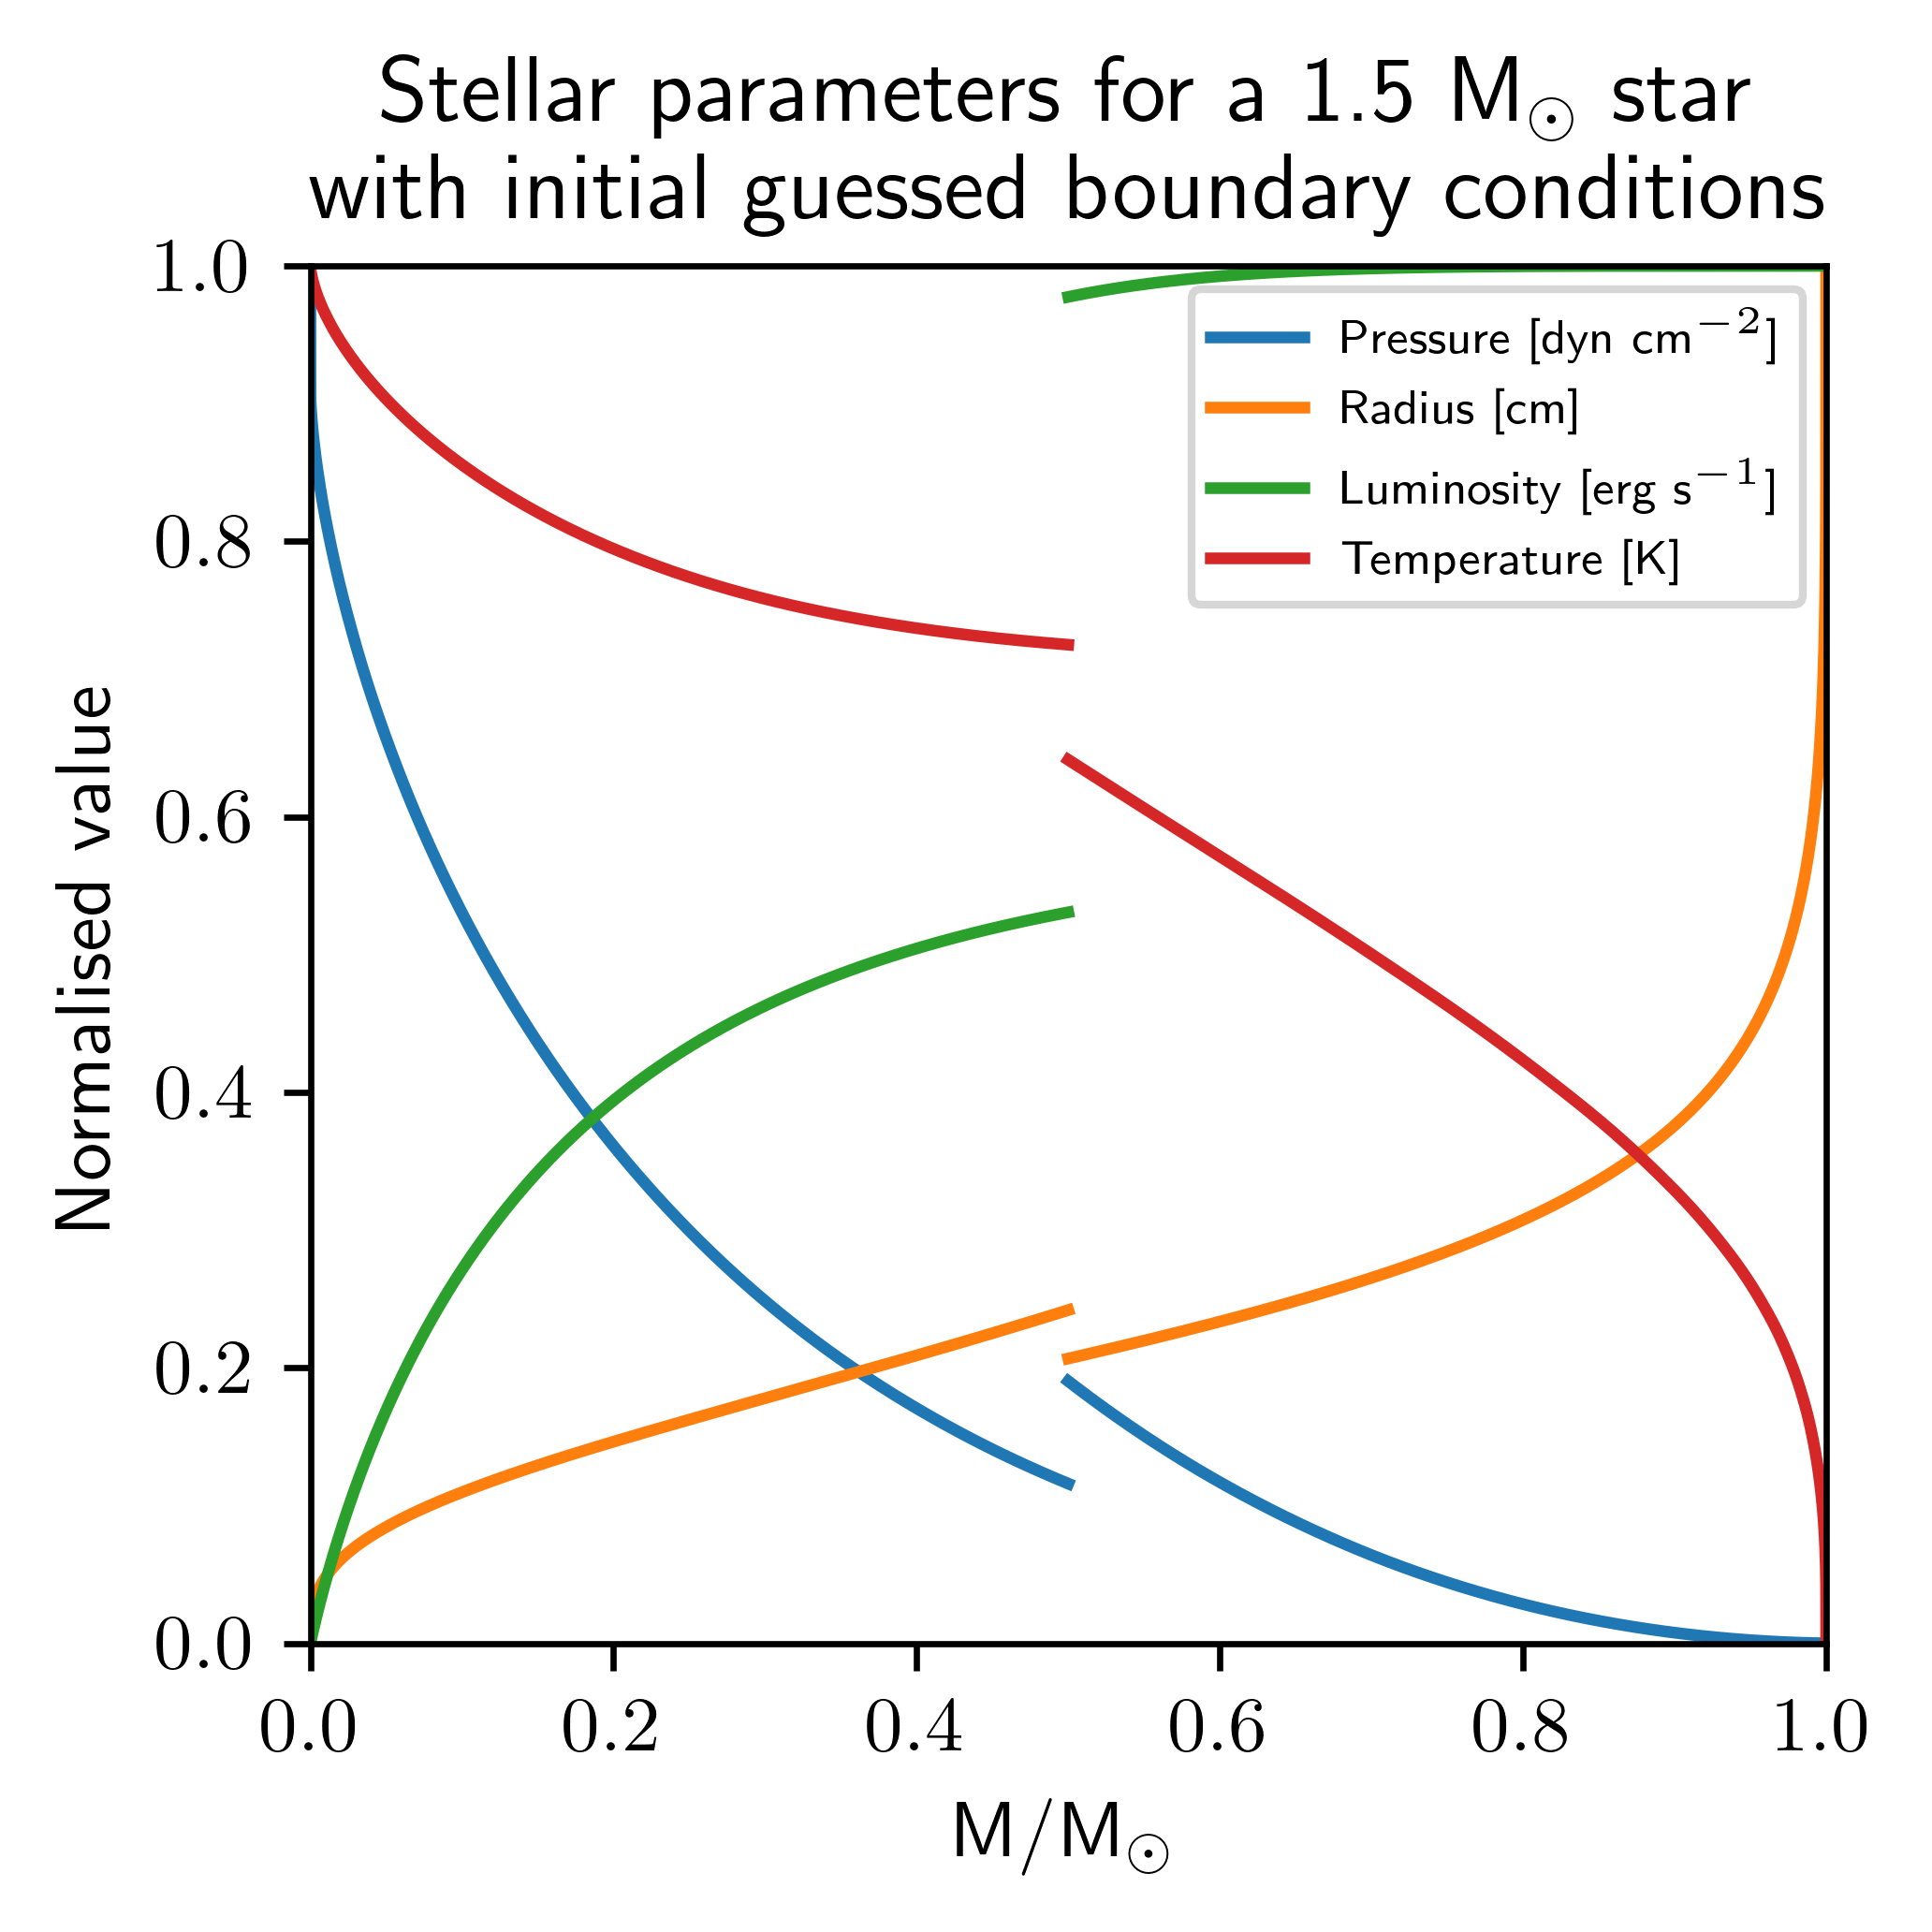

In [15]:
colour = plt.rcParams['axes.prop_cycle'].by_key()['color']
label = ['Pressure [dyn cm$^{-2}$]', 'Radius [cm]', 'Luminosity [erg s$^{-1}$]', 'Temperature [K]']
i = 3
fig, axes = plt.subplots(1, 1, figsize=(3.54, 3.54), dpi=600)
for i in range(4):
    scale = np.abs(sol2.y[i, 0] - sol1.y[i, 0])
    if i == 0 or i == 3:
        zero_point = sol2.y[i, 0]
    else:
        zero_point = sol1.y[i, 0]

    axes.plot(sol1.t/M, (sol1.y[i] - zero_point) / scale, color=colour[i], label=label[i])
    axes.plot(sol2.t/M, (sol2.y[i] - zero_point) / scale, color=colour[i])

axes.legend(fontsize="6")
axes.set_xlabel('M/M$_\odot$')
axes.set_ylabel('Normalised value')
axes.set_xlim(0, 1)
axes.set_ylim(0, 1)
axes.set_title('Stellar parameters for a 1.5 M$_\odot$ star \n with initial guessed boundary conditions')
fig.tight_layout()
# fig.suptitle(' ')
plt.savefig('figures/4plots_norm_guess.pdf', bbox_inches='tight')

plt.show()

In [35]:
param_scales = [1, 1, 1, 1]
bounds = np.array([[0.5]*4, [1.5]*4]).T
fit = scipy.optimize.minimize(residuals, x0=param_scales, args=(initial_guess, args), bounds=bounds, method='L-BFGS-B')
fit

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6.904996733035027e-07
        x: [ 1.149e+00  1.085e+00  9.765e-01  1.139e+00]
      nit: 16
      jac: [ 7.275e-06  9.852e-06  5.523e-05 -2.080e-05]
     nfev: 155
     njev: 31
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [36]:
# Fitted values
best_fit = initial_guess * fit.x
best_fit

array([2.20573750e+17, 1.02315967e+11, 1.54429190e+34, 1.78875710e+07])

In [37]:
print(best_fit[1]/Rs, best_fit[2]/Ls)

1.4700569957123513 4.03630918786581


In [18]:
sol1, sol2 = shootf(initial_guess * fit.x, args, detailed=True, M_start=1e-5)

In [19]:
(sol1.y[:, -1] - sol2.y[:, -1])

array([ 7.04666880e+13,  7.82907571e+07, -2.20782622e+29, -9.14900865e+02])

In [20]:
scale = (sol1.y[:, 0] - sol2.y[:, 0])
diff_frac = (sol1.y[:, -1] - sol2.y[:, -1]) / best_fit
diff_frac

array([ 3.19469965e-04,  7.65186114e-04, -1.42966898e-05, -5.11472947e-05])

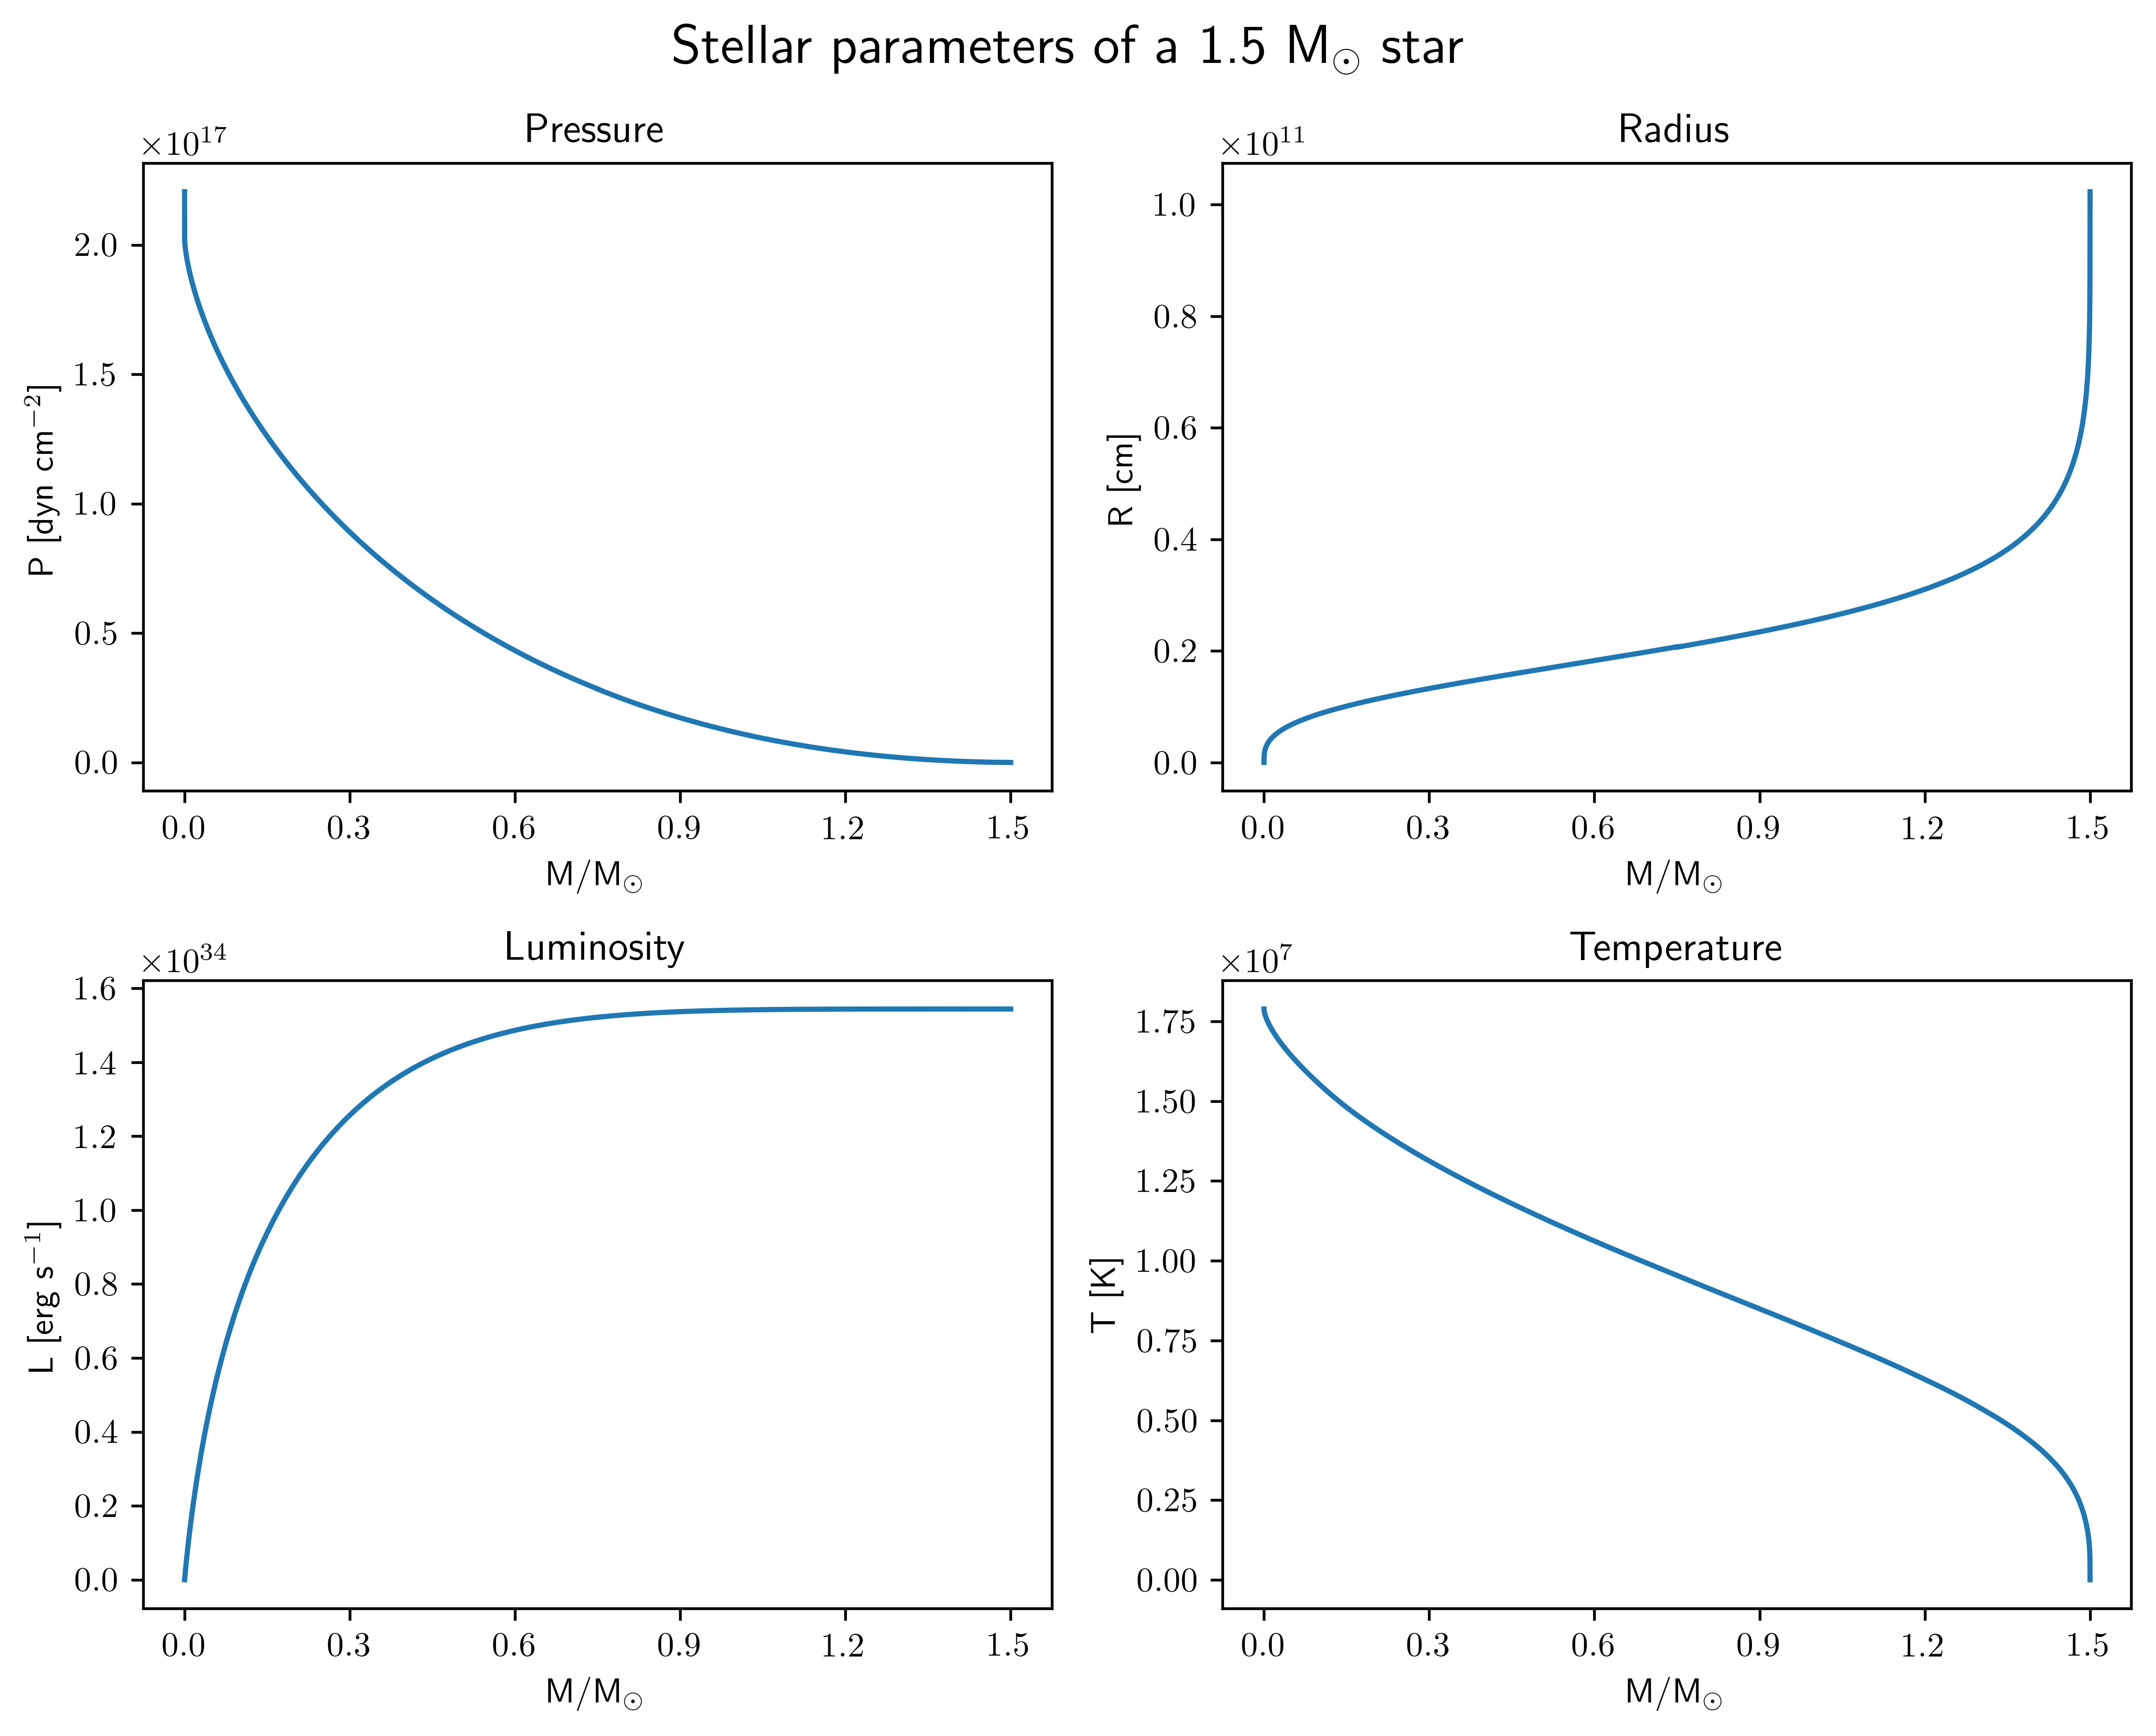

In [21]:
# plot 4 graphs in 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(3.54*2.5, 3.54*2), dpi=600)
axs[0, 0].plot(sol1.t/Ms, sol1.y[0, :], color='#1f77b4')
axs[0, 0].plot(sol2.t/Ms, sol2.y[0, :], color='#1f77b4')
axs[0, 0].set_title('Pressure')
axs[0, 0].set_xlabel('M/M$_\odot$')
axs[0, 0].set_ylabel('P [dyn cm$^{-2}$]')
axs[0, 0].set_xticks(np.linspace(0, 1.5, 6))

axs[0, 1].plot(sol1.t/Ms, sol1.y[1, :], color='#1f77b4')
axs[0, 1].plot(sol2.t/Ms, sol2.y[1, :], color='#1f77b4')
axs[0, 1].set_title('Radius')
axs[0, 1].set_xlabel('M/M$_\odot$')
axs[0, 1].set_ylabel('R [cm]')
axs[0, 1].set_xticks(np.linspace(0, 1.5, 6))

axs[1, 0].plot(sol1.t/Ms, sol1.y[2, :], color='#1f77b4')
axs[1, 0].plot(sol2.t/Ms, sol2.y[2, :], color='#1f77b4')
axs[1, 0].set_title('Luminosity')
axs[1, 0].set_xlabel('M/M$_\odot$')
axs[1, 0].set_ylabel('L [erg s$^{-1}$]')
axs[1, 0].set_xticks(np.linspace(0, 1.5, 6))

axs[1, 1].plot(sol1.t/Ms, sol1.y[3, :], color='#1f77b4')
axs[1, 1].plot(sol2.t/Ms, sol2.y[3, :], color='#1f77b4')
axs[1, 1].set_title('Temperature')
axs[1, 1].set_xlabel('M/M$_\odot$')
axs[1, 1].set_ylabel('T [K]')
axs[1, 1].set_xticks(np.linspace(0, 1.5, 6))

fig.suptitle('Stellar parameters of a 1.5 M$_\odot$ star', fontsize=16)

plt.tight_layout()
plt.savefig('figures/4plots.pdf', bbox_inches='tight')
plt.show()

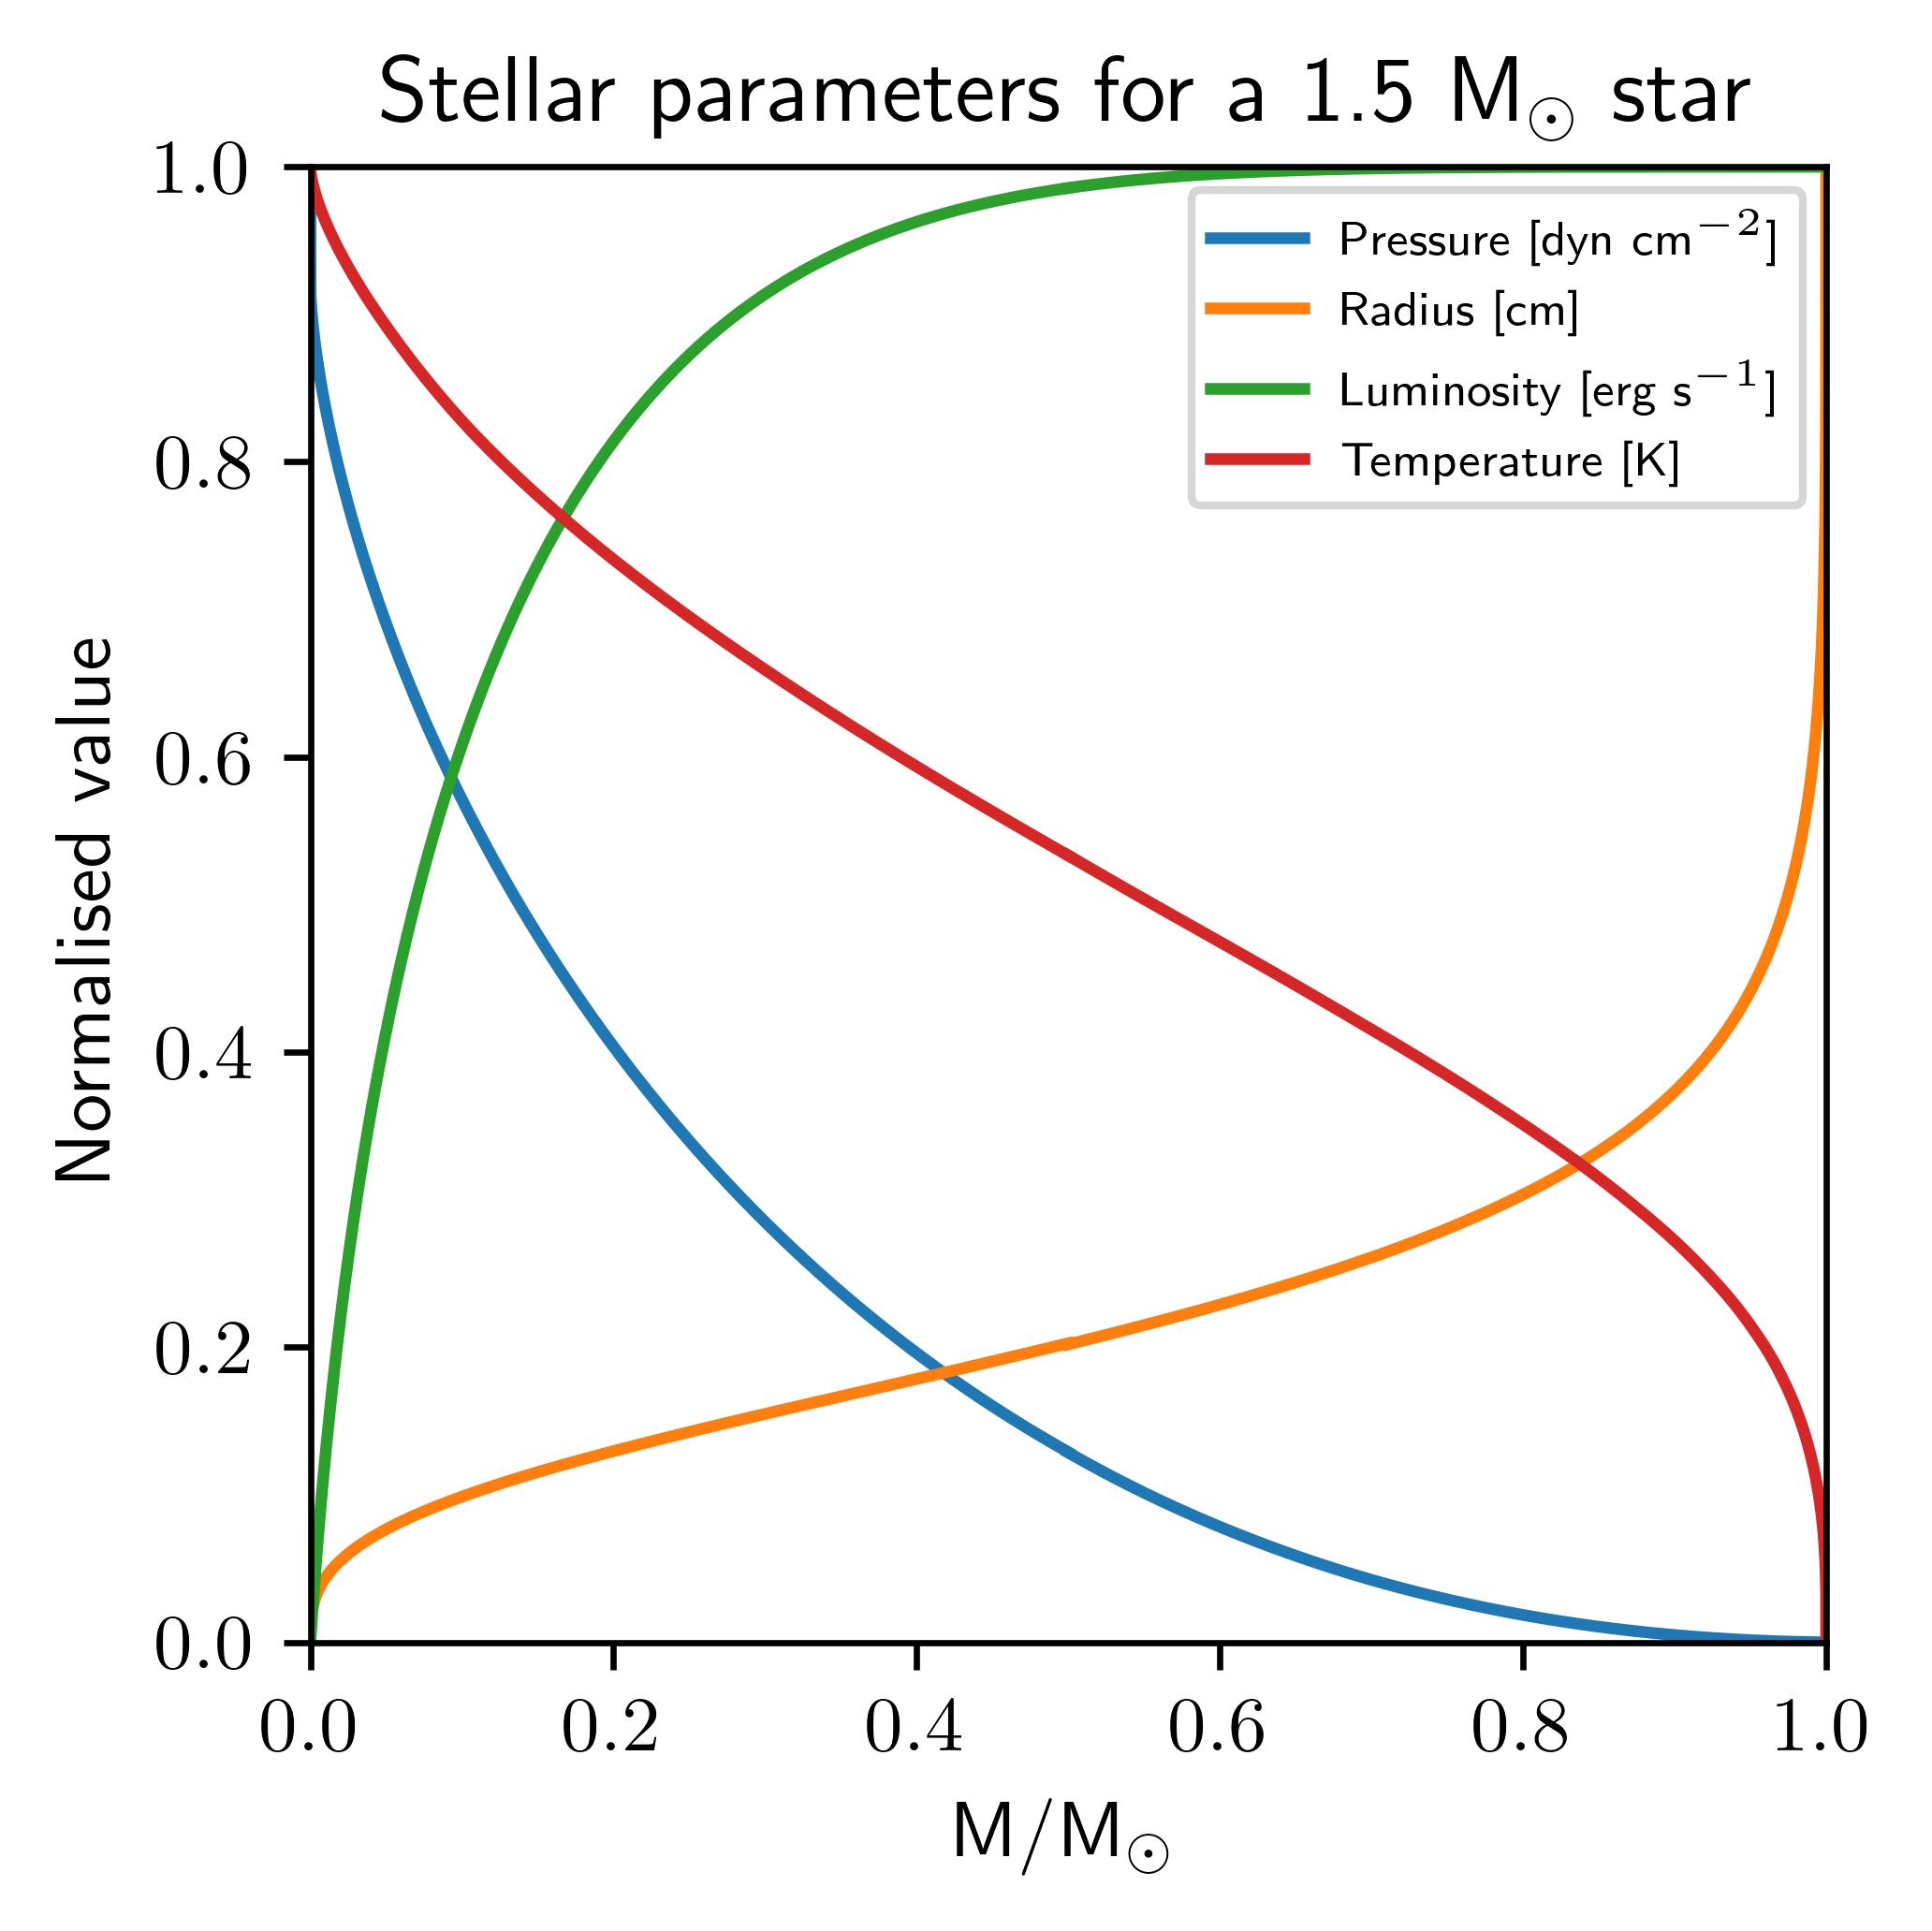

In [22]:
colour = plt.rcParams['axes.prop_cycle'].by_key()['color']
label = ['Pressure [dyn cm$^{-2}$]', 'Radius [cm]', 'Luminosity [erg s$^{-1}$]', 'Temperature [K]']
i = 3
fig, axes = plt.subplots(1, 1, figsize=(3.54, 3.54), dpi=600)
for i in range(4):
    scale = np.abs(sol2.y[i, 0] - sol1.y[i, 0])
    if i == 0 or i == 3:
        zero_point = sol2.y[i, 0]
    else:
        zero_point = sol1.y[i, 0]

    axes.plot(sol1.t/M, (sol1.y[i] - zero_point) / scale, color=colour[i], label=label[i])
    axes.plot(sol2.t/M, (sol2.y[i] - zero_point) / scale, color=colour[i])

axes.legend(fontsize="6")
axes.set_xlabel('M/M$_\odot$')
axes.set_ylabel('Normalised value')
axes.set_xlim(0, 1)
axes.set_ylim(0, 1)
axes.set_title('Stellar parameters for a 1.5 M$_\odot$ star')
fig.tight_layout()
# fig.suptitle(' ')
plt.savefig('figures/4plots_norm.pdf', bbox_inches='tight')

plt.show()

### Comparing with MESA

In [23]:
# read CSV file separated with spaces using pandas
df = pd.read_csv('mesa_results.data', sep="\s+", header=4)
mass_mesa = df['mass']
radius_mesa = np.power(10, df['logR'])
temperature_mesa = np.power(10, df['logT'])
pressure_mesa = np.power(10, df['logP'])
density = np.power(10, df['logRho'])
pp = df['pp']
cno = df['cno']
df

,zone,mass,logR,logT,logRho,logP,x_mass_fraction_H,y_mass_fraction_He,z_mass_fraction_metals,pp,cno,tri_alpha
0,1,1.500000e+00,0.167506,3.850294,-7.498294,4.158000,0.700000,0.280000,0.020000,4.656747e-27,0.000000,0.000000e+00
1,2,1.500000e+00,0.167503,3.852171,-7.485838,4.172402,0.700000,0.280000,0.020000,4.792271e-27,0.000000,0.000000e+00
2,3,1.500000e+00,0.167500,3.854351,-7.472642,4.187863,0.700000,0.280000,0.020000,4.940143e-27,0.000000,0.000000e+00
3,4,1.500000e+00,0.167496,3.857771,-7.454001,4.210070,0.700000,0.280000,0.020000,5.156840e-27,0.000000,0.000000e+00
4,5,1.500000e+00,0.167489,3.862807,-7.431337,4.238018,0.700000,0.280000,0.020000,5.433156e-27,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
815,816,1.875145e-06,-2.496940,7.263812,1.912992,17.304257,0.696542,0.282892,0.020566,7.937995e+01,32.008056,7.867388e-39
816,817,9.375725e-07,-2.597288,7.263824,1.913011,17.304288,0.696542,0.282892,0.020566,7.941010e+01,32.025554,7.878308e-39
817,818,4.687863e-07,-2.697634,7.263832,1.913023,17.304308,0.696542,0.282892,0.020566,7.942910e+01,32.036581,7.885195e-39
818,819,2.343931e-07,-2.797979,7.263837,1.913030,17.304320,0.696542,0.282892,0.020566,7.944108e+01,32.043529,7.889536e-39


In [24]:
eps = (pp + cno).to_numpy()
luminosity = np.zeros(820)

for i in range(819, -1, -1):
    if i == 819:
        luminosity[i] = eps[i] * mass_mesa[i]
    else:
        luminosity[i] = eps[i] * (mass_mesa[i] - mass_mesa[i+1]) + luminosity[i+1]

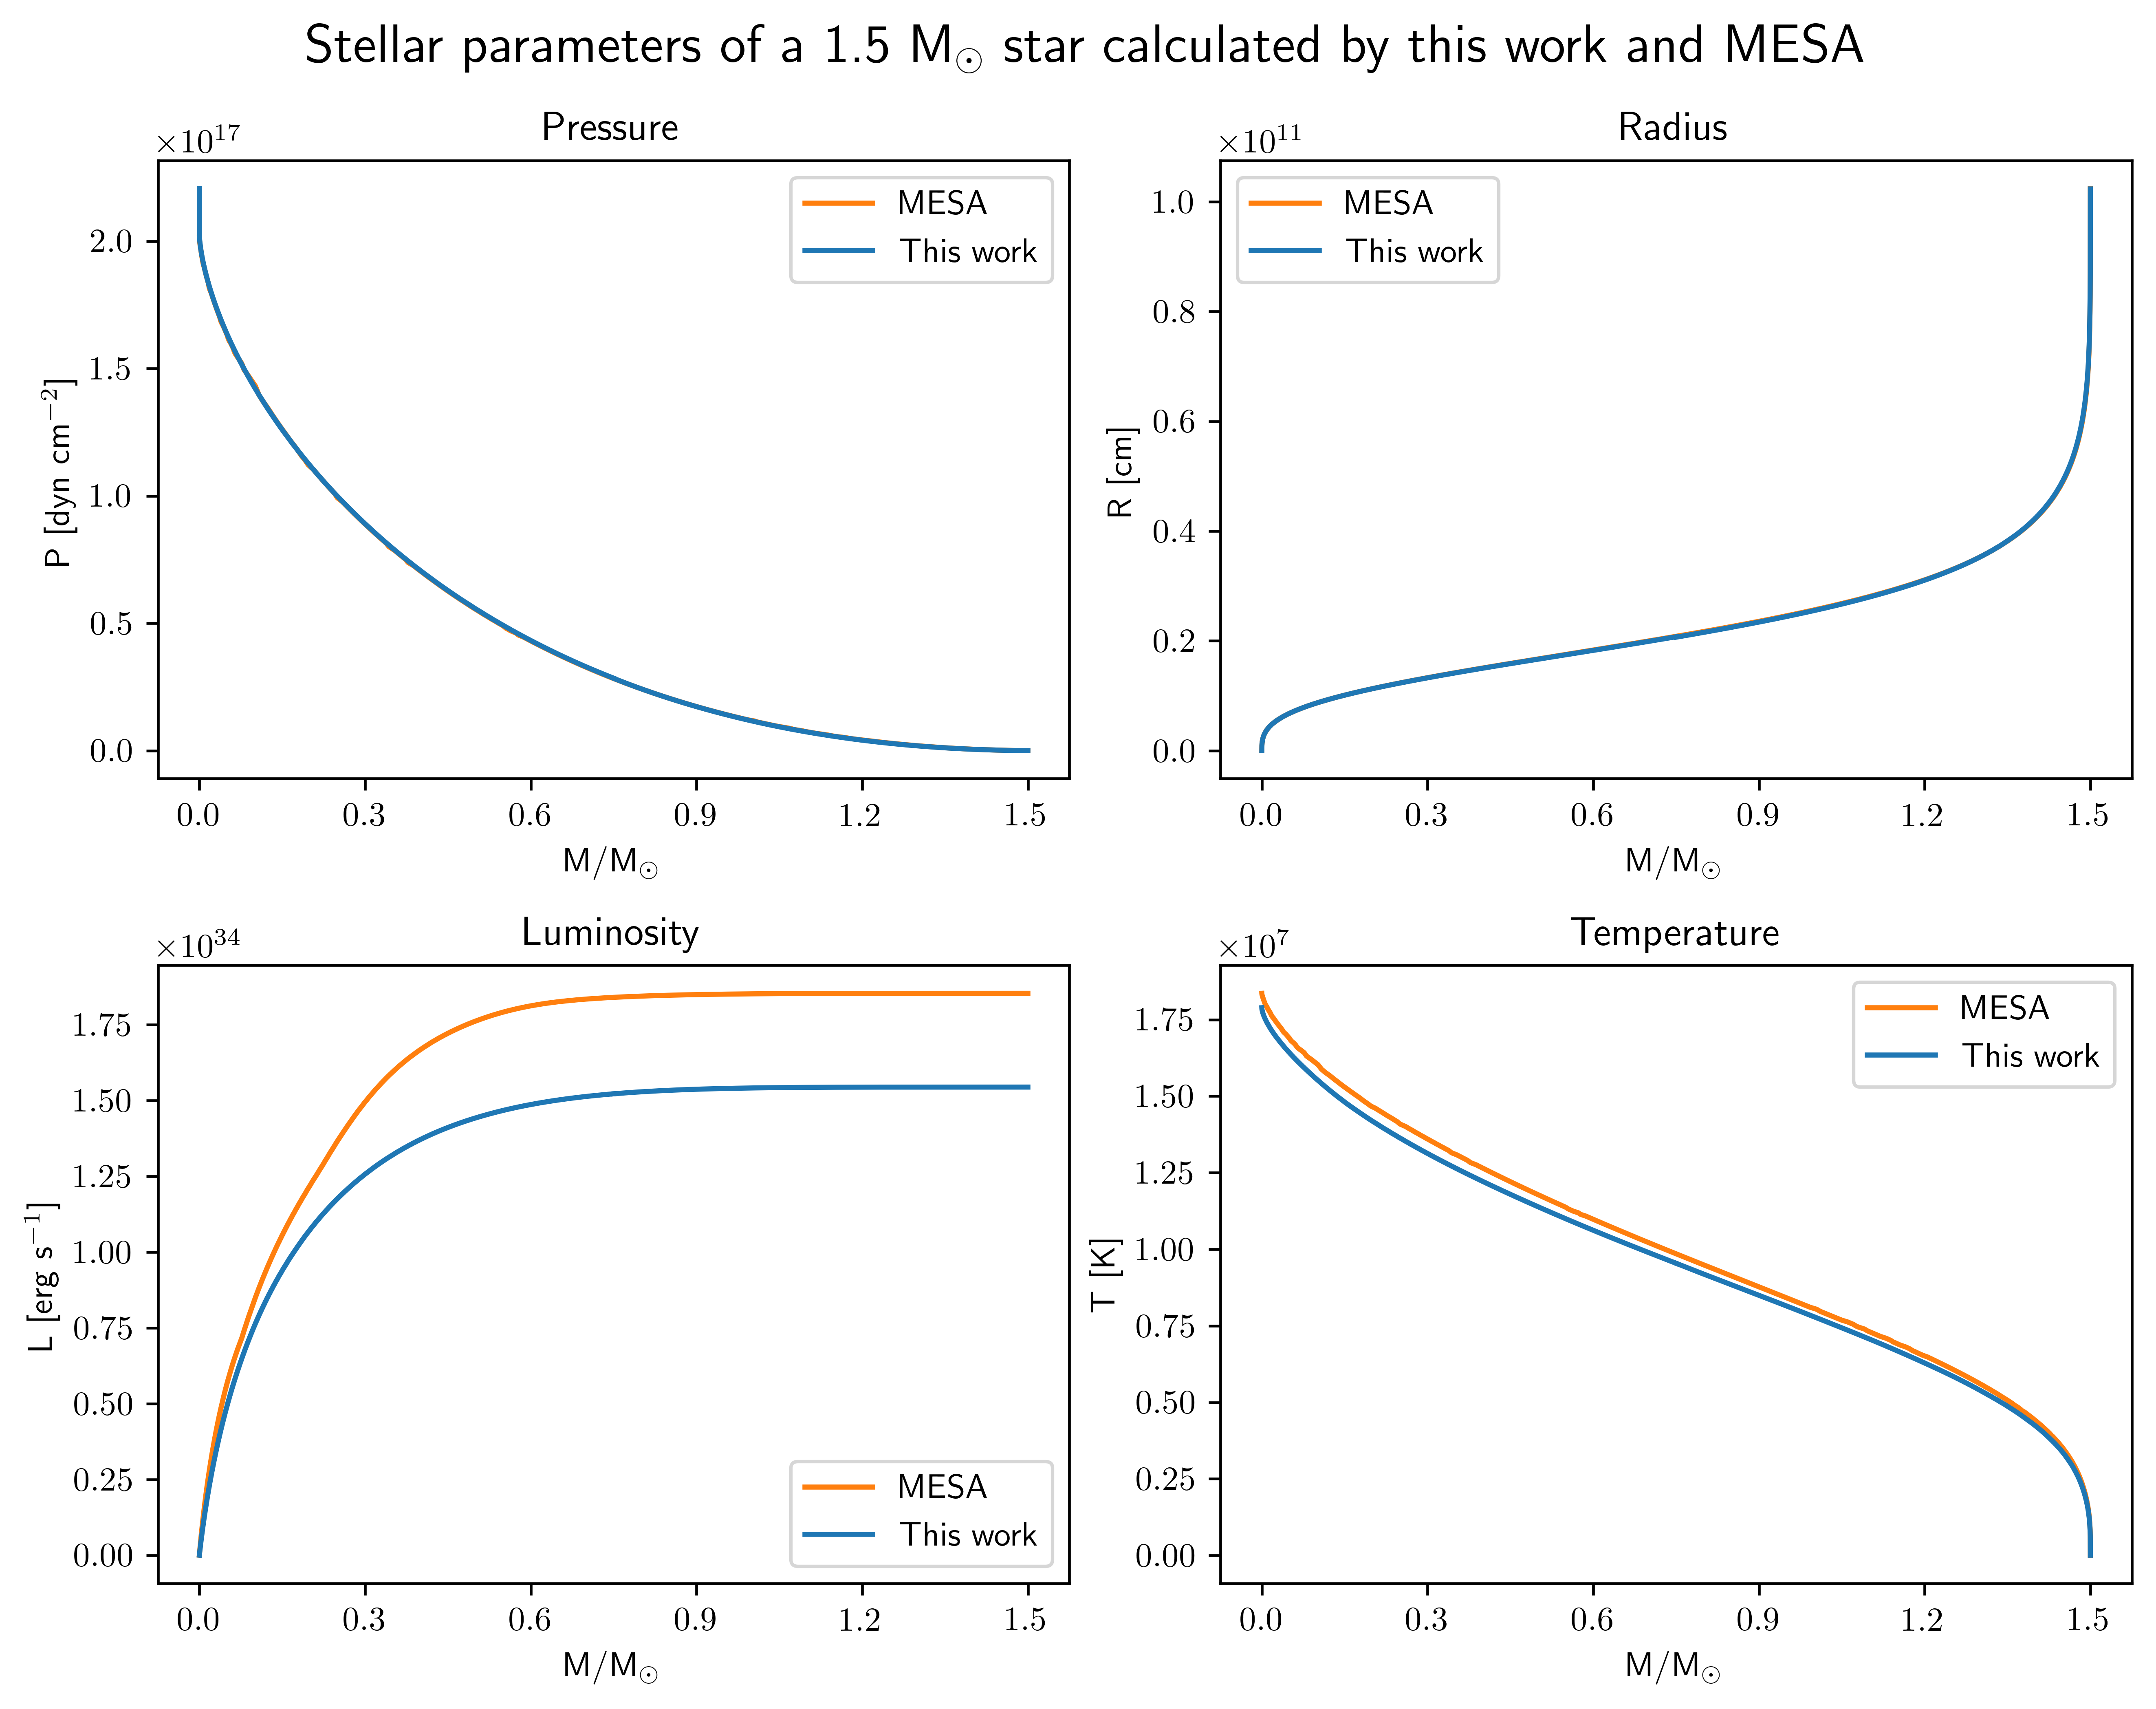

In [25]:
colour = plt.rcParams['axes.prop_cycle'].by_key()['color']

# plot 4 graphs in 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(3.54*2.5, 3.54*2), dpi=600)

axs[0, 0].plot(mass_mesa, pressure_mesa, color=colour[1], label='MESA')
axs[0, 0].plot(sol1.t/Ms, sol1.y[0, :], color=colour[0], label='This work')
axs[0, 0].plot(sol2.t/Ms, sol2.y[0, :], color=colour[0])
axs[0, 0].set_title('Pressure')
axs[0, 0].set_xlabel('M/M$_\odot$')
axs[0, 0].set_ylabel('P [dyn cm$^{-2}$]')
axs[0, 0].set_xticks(np.linspace(0, 1.5, 6))
axs[0, 0].legend()

axs[0, 1].plot(mass_mesa, radius_mesa * Rs, color=colour[1], label='MESA')
axs[0, 1].plot(sol1.t/Ms, sol1.y[1, :], color=colour[0], label='This work')
axs[0, 1].plot(sol2.t/Ms, sol2.y[1, :], color=colour[0])
axs[0, 1].set_title('Radius')
axs[0, 1].set_xlabel('M/M$_\odot$')
axs[0, 1].set_ylabel('R [cm]')
axs[0, 1].set_xticks(np.linspace(0, 1.5, 6))
axs[0, 1].legend()

axs[1, 0].plot(mass_mesa, luminosity * Ms, color=colour[1], label='MESA')
axs[1, 0].plot(sol1.t/Ms, sol1.y[2, :], color='#1f77b4', label='This work')
axs[1, 0].plot(sol2.t/Ms, sol2.y[2, :], color='#1f77b4')
axs[1, 0].set_title('Luminosity')
axs[1, 0].set_xlabel('M/M$_\odot$')
axs[1, 0].set_ylabel('L [erg s$^{-1}$]')
axs[1, 0].set_xticks(np.linspace(0, 1.5, 6))
axs[1, 0].legend()


axs[1, 1].plot(mass_mesa, temperature_mesa, color=colour[1], label='MESA')
axs[1, 1].plot(sol1.t/Ms, sol1.y[3, :], color='#1f77b4', label='This work')
axs[1, 1].plot(sol2.t/Ms, sol2.y[3, :], color='#1f77b4')
axs[1, 1].set_title('Temperature')
axs[1, 1].set_xlabel('M/M$_\odot$')
axs[1, 1].set_ylabel('T [K]')
axs[1, 1].set_xticks(np.linspace(0, 1.5, 6))
axs[1, 1].legend()


fig.suptitle('Stellar parameters of a 1.5 M$_\odot$ star calculated by this work and MESA', fontsize=16)
plt.tight_layout()
plt.savefig('figures/4plots_mesa.pdf', bbox_inches='tight')
plt.show()

In [26]:
mesa_log = np.array([17.3043306712337, 0.167506265445817, 0.687599155165118, 7.2638409097449])
mesa_result = np.power(10, mesa_log)
mesa_result = mesa_result * [1, 69570000000, 3.828E+033, 1]
mesa_result

array([2.01525808e+17, 1.02312399e+11, 1.86453734e+34, 1.83586571e+07])

In [27]:
(best_fit - mesa_result) / mesa_result

array([ 9.45186214e-02,  3.48708466e-05, -1.71755982e-01, -2.56601611e-02])

#### creating results table

In [28]:
mass_df = np.concatenate((sol1.t, np.flip(sol2.t, axis=0)), axis=0)
data_df = np.concatenate((sol1.y, np.flip(sol2.y, axis=1)), axis=1).transpose()
df_result = pd.DataFrame(data = data_df, columns=['P', 'R', 'L', 'T'])
df_result['Mr'] = mass_df
df_result = df_result[['Mr', 'P', 'R', 'L', 'T']]

In [29]:
df_result['rho'] = get_density_rho(df_result['P'].to_numpy(), df_result['T'].to_numpy(), mu)
df_result['epsilon_pp'] = get_epsilon_pp(df_result['rho'].to_numpy(), df_result['T'].to_numpy())
df_result['epsilon_cno'] = get_epsilon_cno(df_result['rho'].to_numpy(), df_result['T'].to_numpy())
df_result['epsilon'] = get_epsilon_energy_generation(df_result['rho'].to_numpy(), df_result['T'].to_numpy())
df_result['kappa'] = get_opacity(opacity_interp, df_result['rho'].to_numpy(), df_result['T'].to_numpy())

df_result['del_rad'] = get_del_rad(df_result['Mr'].to_numpy(), df_result['P'].to_numpy(), df_result['L'].to_numpy(), df_result['T'].to_numpy(), df_result['kappa'].to_numpy())
df_result['del_ad'] = get_del_ad(df_result['P'].to_numpy(), df_result['T'].to_numpy())
df_result['del_nabla'] = get_del_nabla(df_result['Mr'].to_numpy(), df_result['P'].to_numpy(), df_result['L'].to_numpy(), df_result['T'].to_numpy(), df_result['kappa'].to_numpy())
df_result['e_rad'] = [1 if df_result['del_nabla'][i] == df_result['del_rad'][i] else 0 for i in range(len(df_result['del_nabla']))]
df_result['e_ad'] = [1 if df_result['del_nabla'][i] == df_result['del_ad'][i] else 0 for i in range(len(df_result['del_nabla']))]

In [30]:
df_result

,Mr,P,R,L,T,rho,epsilon_pp,epsilon_cno,epsilon,kappa,del_rad,del_ad,del_nabla,e_rad,e_ad
0,2.983500e+28,2.205737e+17,9.288447e+06,2.837101e+25,1.788757e+07,9.115978e+01,4.462157e+01,5.292298e+01,9.754456e+01,0.958570,0.000008,0.398606,0.000008,1,0
1,1.790219e+29,2.020427e+17,7.582562e+08,1.287273e+31,1.785998e+07,8.362191e+01,4.065974e+01,4.716424e+01,8.782399e+01,0.936356,0.527321,0.398488,0.398488,0,1
2,3.282089e+29,2.016849e+17,9.557176e+08,2.558337e+31,1.784736e+07,8.353290e+01,4.051064e+01,4.649501e+01,8.700564e+01,0.937085,0.572682,0.398490,0.398490,0,1
3,4.773958e+29,2.014029e+17,1.093656e+09,3.818913e+31,1.783742e+07,8.346273e+01,4.039334e+01,4.597347e+01,8.636681e+01,0.937660,0.588566,0.398491,0.398491,0,1
4,6.265827e+29,2.011545e+17,1.204184e+09,5.070893e+31,1.782865e+07,8.340087e+01,4.029012e+01,4.551815e+01,8.580826e+01,0.938169,0.596202,0.398492,0.398492,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2.982903e+33,1.628299e+11,8.388878e+10,1.544292e+34,7.466902e+05,1.606230e-03,1.628075e-13,1.926838e-50,1.628075e-13,19.552639,0.209131,0.394391,0.209131,1,0
19996,2.983052e+33,1.164065e+11,8.509870e+10,1.544292e+34,6.978375e+05,1.228276e-03,5.563038e-14,3.347899e-52,5.563038e-14,20.794122,0.208410,0.394026,0.208410,1,0
19997,2.983202e+33,7.290559e+10,8.670679e+10,1.544292e+34,6.337314e+05,8.467118e-04,1.177563e-14,9.055222e-55,1.177563e-14,22.958962,0.211880,0.393530,0.211880,1,0
19998,2.983351e+33,3.317563e+10,8.919817e+10,1.544292e+34,5.373690e+05,4.540409e-04,7.611383e-16,2.407438e-59,7.611383e-16,26.729073,0.217114,0.392682,0.217114,1,0


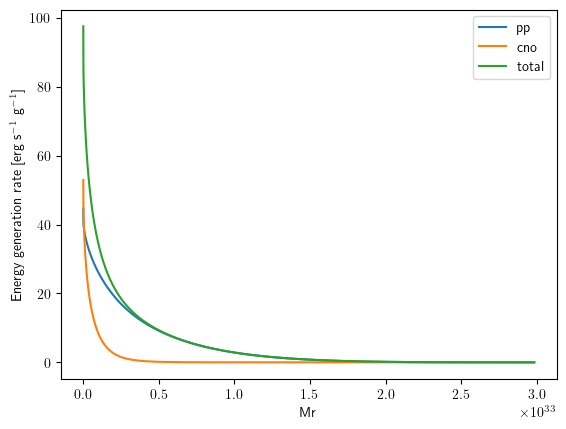

In [31]:
plt.plot(df_result['Mr'], df_result['epsilon_pp'], label='pp')
plt.plot(df_result['Mr'], df_result['epsilon_cno'], label='cno')
plt.plot(df_result['Mr'], df_result['epsilon'], label='total')
plt.ylabel('Energy generation rate [erg s$^{-1}$ g$^{-1}$]')
plt.xlabel('Mr')
plt.legend()
plt.show()

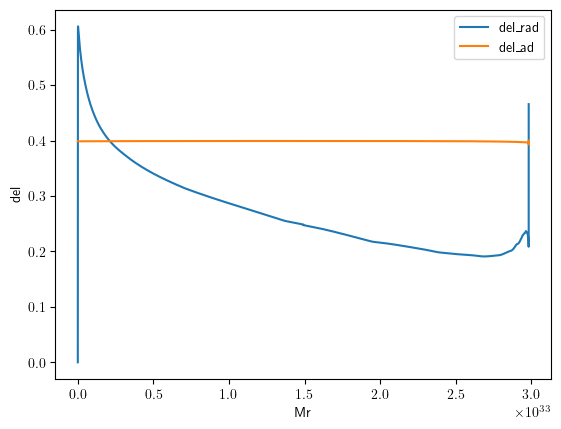

In [32]:
plt.plot(df_result['Mr'], df_result['del_rad'], label='del_rad')
plt.plot(df_result['Mr'], df_result['del_ad'], label='del_ad')
plt.ylabel('del')
plt.xlabel('Mr')
plt.legend()
plt.show()

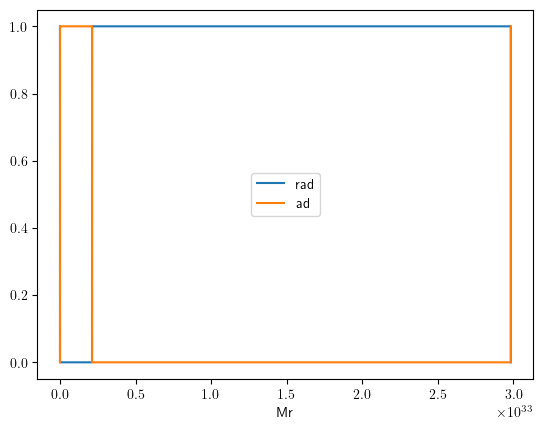

In [33]:
plt.plot(df_result['Mr'], df_result['e_rad'], label='rad')
plt.plot(df_result['Mr'], df_result['e_ad'], label='ad')
plt.xlabel('Mr')
plt.legend()
plt.show()

In [34]:
df_result.to_csv('stellar_structure_result.csv', index=True)